# Noise (and signal) correlations

This notebook analyzes the noise and signal correlation data calculated by the `scripts/pairwise_correlations.py` script.

In [1]:
import <- function(pkg) { library(pkg, warn.conflicts=F, quietly=T, character.only=T) }
import("repr")
import("stringr")
import("tidyr")
import("dplyr")
import("ggplot2")
import("lme4")
import("emmeans")
import("xtable")


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'



In [2]:
options(repr.matrix.max.cols=15, repr.matrix.max.rows=20)
my.theme <- theme(legend.text=element_text(size=6),
                  legend.title=element_text(size=6),
                  plot.title = element_text(size=7, hjust=0.5),
                  axis.line=element_line(linewidth=0.25),
                  axis.ticks=element_line(linewidth=0.25),
                  axis.ticks.length=unit(0.05, "cm"),
                  axis.title=element_text(size=7),
                  axis.text=element_text(size=6),
                  strip.placement="outside",
                  strip.text=element_text(size=7),
                  strip.background=element_blank())
no.legend <- theme(legend.position="none")
update_geom_defaults("point", list(fill="white", shape=21, size=0.8))
update_geom_defaults("line", list(linewidth=0.4))


## Loading data and first steps of analysis

In [3]:
# Metadata
birds <- (
    data.table::fread("../inputs/bird_metadata.csv")
    |> filter(behavior == "no")
)
sites <- data.table::fread("../inputs/recording_metadata.csv")
all_sites <- (
   sites
   |> mutate(bird=str_match(site, "[:alnum:]+")[,1])
   |> inner_join(birds, by="bird")
   |> filter(area %in% c("deep", "intermediate", "superficial"), stim_amplitude == "okay")
   |> mutate(area=forcats::fct_recode(area, "L1/CM"="superficial", "L2a/L2b"="intermediate", "L3/NCM"="deep") |> forcats::fct_relevel(c("L2a/L2b", "L1/CM", "L3/NCM")),
             group=factor(group, levels=c("CR", "PR")))
)

In [4]:
# Need to have run `python scripts/unit_waveforms.py -o build inputs/all_units.txt`
unit_spike_features <- (
    data.table::fread("../build/mean_spike_features.csv") %>%
    mutate(spike=factor(spike, levels=c("wide", "narrow"), exclude="")) %>%
    filter(!is.na(spike))
)
# Need to have run `single-unit-analysis` notebook to identify responsive units
responsive_units <- data.table::fread("../inputs/responsive_units.txt", header=F, col.names=c("unit"))
    
# Need to have run `scripts/extract_channel.py inputs/all_units.tbl > build/unit_channels.csv"
units <- (
    data.table::fread("../build/unit_channels.csv")
    |> semi_join(responsive_units, by="unit")
    |> inner_join(unit_spike_features |> select(unit, spike), by="unit")
)

In [5]:
# Pairwise correlations. Need to have run `batch/pairwise_correlations.sh < inputs/recording_metadata.csv`u
header <- data.table::fread(cmd='find ../build/ -name "*_correlations.csv" | head -n1 | xargs head -n1', header=T)
unit_correlations <- tibble(data.table::fread(cmd='find ../build/ -name "*_correlations.csv" | xargs tail -q -n+2', header=F))
names(unit_correlations) <- names(header)

In [6]:
ucorr <- (
    unit_correlations
    # drop all comparisons where signal or noise correlation can't be calculated (typically because responses are too weak)
    |> filter(!is.na(evoked_noise), !is.na(signal))
    # look up channel and spike type. This will also remove non-responsive units
    |> inner_join(units |> rename_with(function(s) str_c(s, "_1")), by="unit_1")
    |> inner_join(units |> rename_with(function(s) str_c(s, "_2")), by="unit_2")
    # exclude pairs on the same electrode (might change this if we calculate distance)
    |> filter(channel_1 != channel_2)
    |> mutate(site=str_match(unit_1, "[:alnum:]+_\\d+_\\d+")[,1])
    |> inner_join(all_sites, by="site")
    |> mutate(conn_type=ifelse(spike_1=="wide", ifelse(spike_2=="wide", "BS-BS", "BS-NS"), ifelse(spike_2=="wide", "BS-NS", "NS-NS")))
)

In [7]:
## number of pairs by area, condition, and cell type
df <- (
    ucorr
    |> filter(conn_type != "BS-NS")
    |> xtabs(~ area + group + conn_type, data=_)
    |> addmargins(c(1,3))
    |> as.data.frame()
    |> arrange(area)
    |> pivot_wider(names_from=c(area, group), values_from=Freq, values_fill=0)
)
df

conn_type,L2a/L2b_CR,L2a/L2b_PR,L1/CM_CR,L1/CM_PR,L3/NCM_CR,L3/NCM_PR,Sum_CR,Sum_PR
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BS-BS,1188,129,1957,841,2111,305,5256,1275
NS-NS,479,62,619,76,355,127,1453,265
Sum,1667,191,2576,917,2466,432,6709,1540


In [8]:
print(xtable(df, digits=0), type="latex")

% latex table generated in R 4.4.1 by xtable 1.8-4 package
% Thu Oct  3 09:16:45 2024
\begin{table}[ht]
\centering
\begin{tabular}{rlrrrrrrrr}
  \hline
 & conn\_type & L2a/L2b\_CR & L2a/L2b\_PR & L1/CM\_CR & L1/CM\_PR & L3/NCM\_CR & L3/NCM\_PR & Sum\_CR & Sum\_PR \\ 
  \hline
1 & BS-BS & 1188 & 129 & 1957 & 841 & 2111 & 305 & 5256 & 1275 \\ 
  2 & NS-NS & 479 & 62 & 619 & 76 & 355 & 127 & 1453 & 265 \\ 
  3 & Sum & 1667 & 191 & 2576 & 917 & 2466 & 432 & 6709 & 1540 \\ 
   \hline
\end{tabular}
\end{table}


### Raw data plots

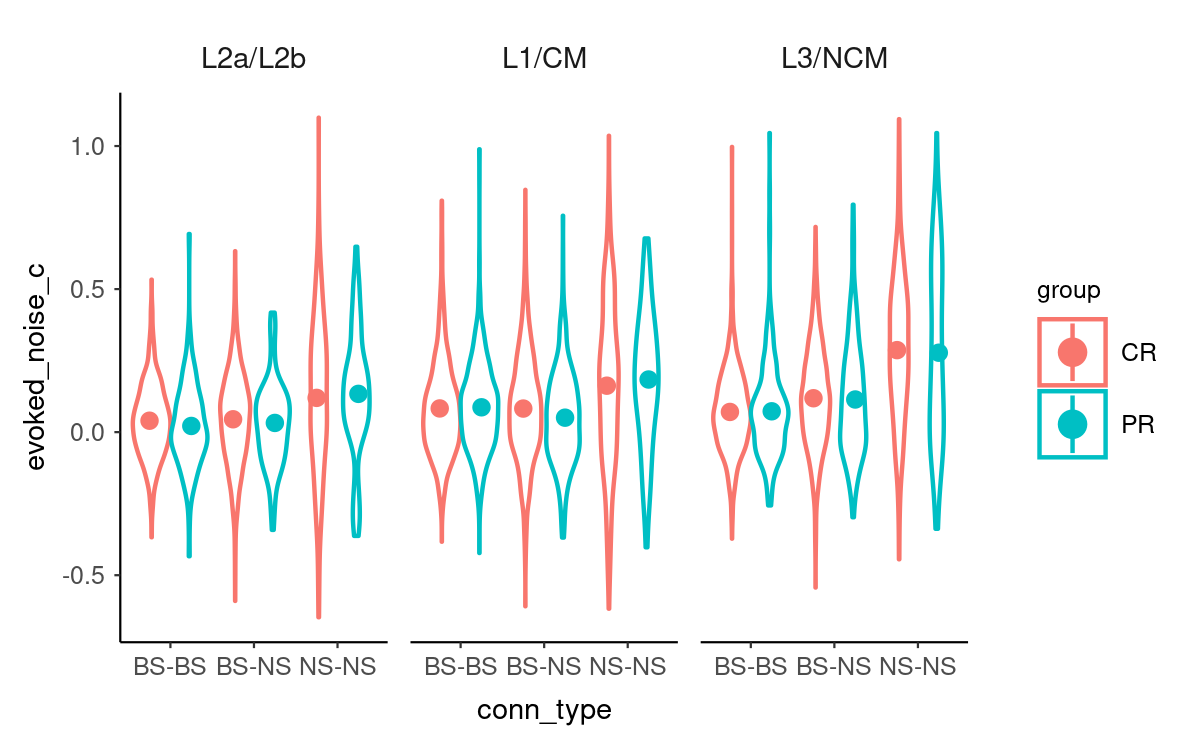

In [9]:
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
(
    ucorr
    |> ggplot(aes(conn_type, evoked_noise_c, color=group))
    + facet_grid(~ area)
    + geom_violin()
    + stat_summary(fun.data="mean_se", fatten=1.5, position=position_dodge(width=1.0))
    + theme_classic() + my.theme
)

Warning message:
“Removed 42 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Removed 42 rows containing non-finite values (`stat_summary()`).”


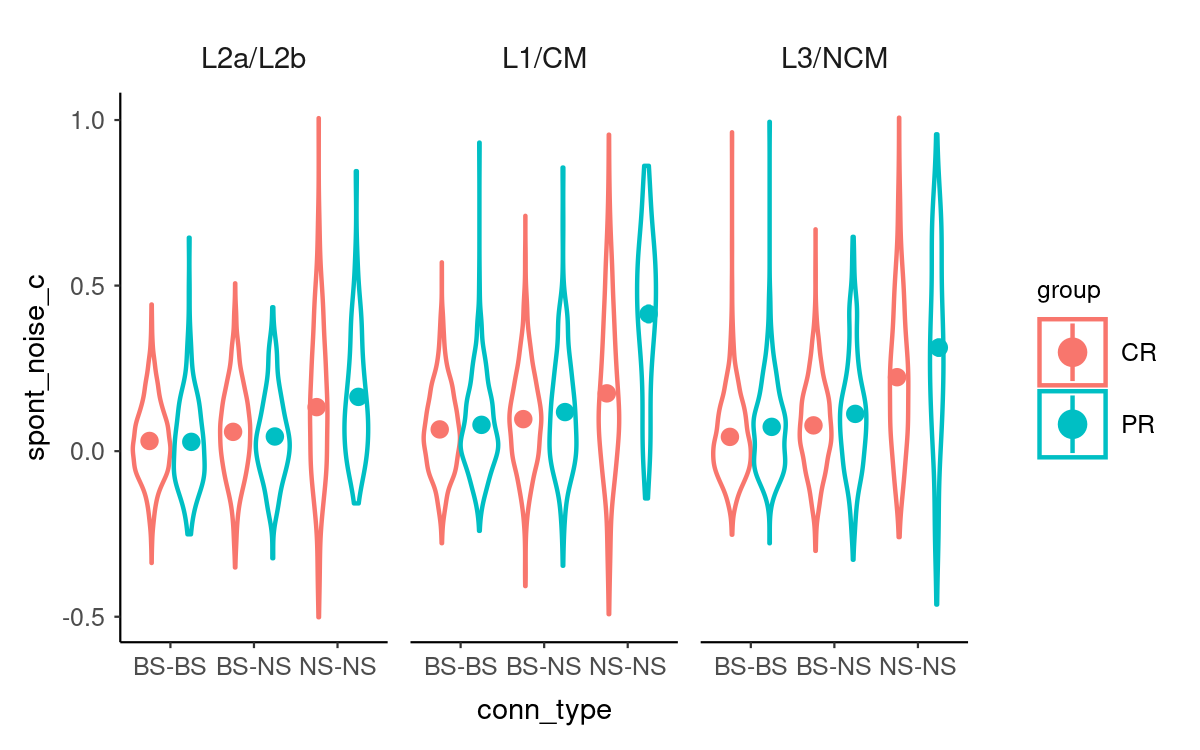

In [10]:
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
(
    ucorr
    |> ggplot(aes(conn_type, spont_noise_c, color=group))
    + facet_grid(~ area)
    + geom_violin()
    + stat_summary(fun.data="mean_se", fatten=1.5, position=position_dodge(width=1.0))
    + theme_classic() + my.theme
)

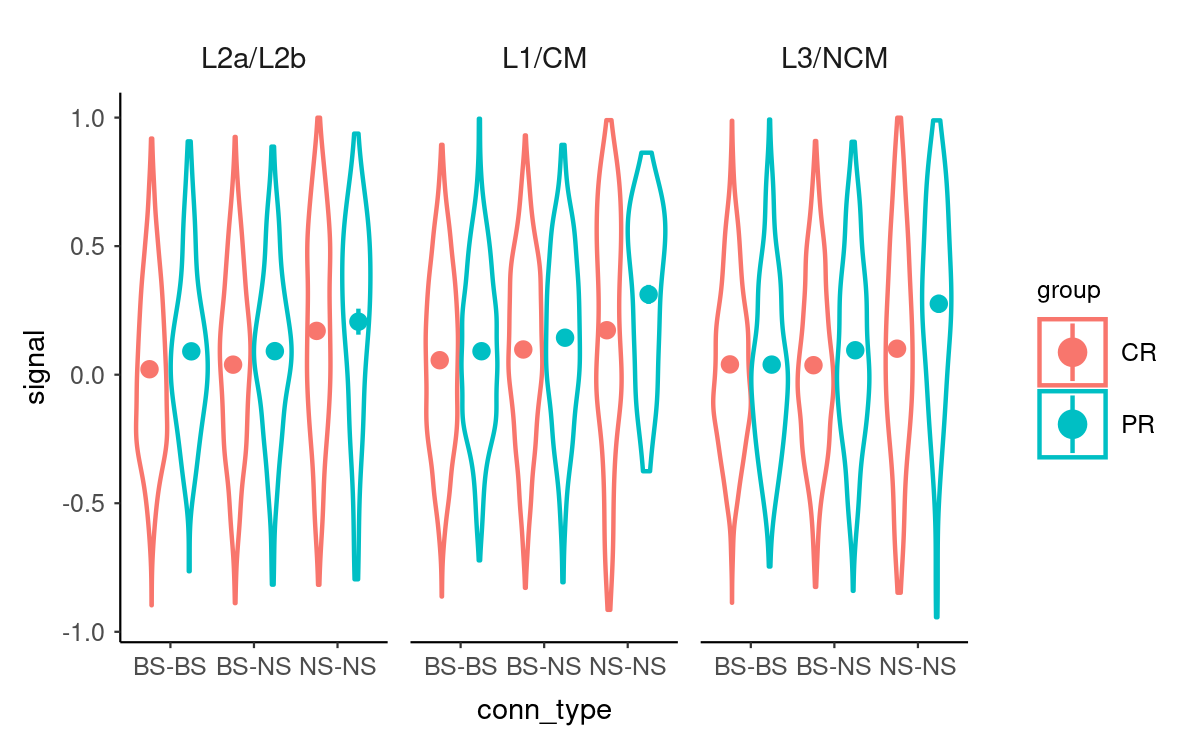

In [11]:
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
(
    ucorr
    |> ggplot(aes(conn_type, signal, color=group))
    + facet_grid(~ area)
    + geom_violin()
    + stat_summary(fun.data="mean_se", fatten=1.5, position=position_dodge(width=1.0))
    + theme_classic() + my.theme
)

### Evoked noise correlation - linear model - pairs

In [12]:
fm_noise_corr <- (
    ucorr
    |> filter(conn_type != "BS-NS")
    |> lm(evoked_noise_c ~ area*conn_type*group, data=_)
)
emmeans(fm_noise_corr, ~ group | area*conn_type) |> contrast("pairwise")

area = L2a/L2b, conn_type = BS-BS:
 contrast estimate      SE   df t.ratio p.value
 CR - PR   0.01831 0.01689 8237   1.084  0.2782

area = L1/CM, conn_type = BS-BS:
 contrast estimate      SE   df t.ratio p.value
 CR - PR  -0.00399 0.00751 8237  -0.531  0.5952

area = L3/NCM, conn_type = BS-BS:
 contrast estimate      SE   df t.ratio p.value
 CR - PR  -0.00225 0.01116 8237  -0.202  0.8403

area = L2a/L2b, conn_type = NS-NS:
 contrast estimate      SE   df t.ratio p.value
 CR - PR  -0.01401 0.02459 8237  -0.570  0.5689

area = L1/CM, conn_type = NS-NS:
 contrast estimate      SE   df t.ratio p.value
 CR - PR  -0.02159 0.02214 8237  -0.975  0.3297

area = L3/NCM, conn_type = NS-NS:
 contrast estimate      SE   df t.ratio p.value
 CR - PR   0.00908 0.01884 8237   0.482  0.6299


In [13]:
joint_tests(fm_noise_corr)

,model term,df1,df2,F.ratio,p.value
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,area,2,8237,57.994,9.754407e-26
5,conn_type,1,8237,325.194,2.490004e-71
7,group,1,8237,0.109,7.414216e-01
2,area:conn_type,2,8237,34.794,8.964492e-16
4,area:group,2,8237,0.581,5.592315e-01
6,conn_type:group,1,8237,0.777,3.780290e-01
3,area:conn_type:group,2,8237,0.804,4.475476e-01


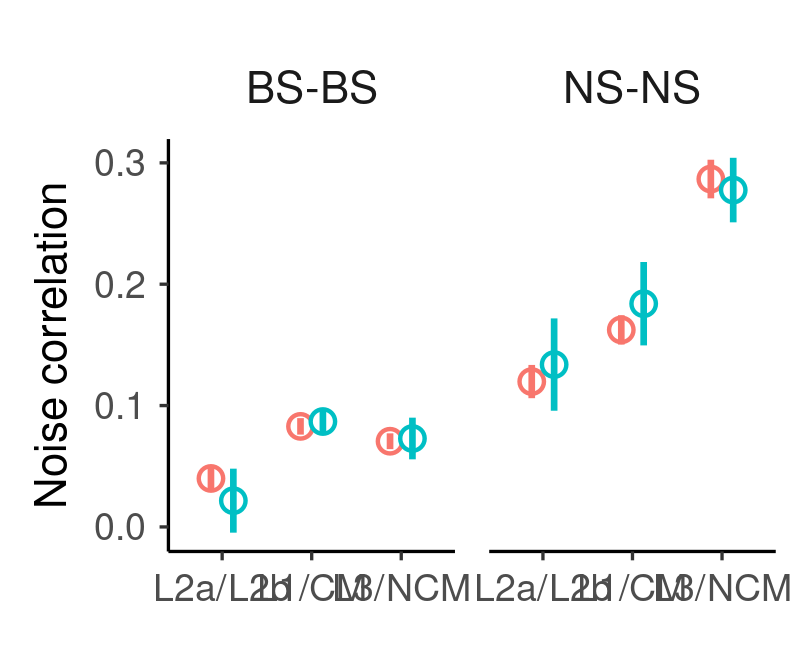

In [14]:
options(repr.plot.width=1.8, repr.plot.height=1.45, repr.plot.res = 450)
p <- (
    fm_noise_corr
    |> emmeans(~ group*conn_type*area)
    |> confint(level=0.90, type="response")
    |> ggplot(aes(area, emmean, color=group))
    + facet_wrap(~ conn_type)
    + geom_point(position=position_dodge(width=0.5), size=1.5)
    + geom_linerange(aes(ymin=lower.CL, ymax=upper.CL), position=position_dodge(width=0.5))
    + scale_x_discrete(name=NULL)
    + scale_y_continuous("Noise correlation")
    + theme_classic() + my.theme + no.legend
)
p 

In [15]:
pdf("../figures/noise_correlations.pdf", width=2.4, height=1.75)
print(p)
dev.off()

png 
  2

### Spontaneous noise correlation - linear model - pairs

In [16]:
fm_corr <- lm(spont_noise_c ~ area*conn_type*group, ucorr)
emmeans(fm_corr, ~ group | area*conn_type) |> contrast("pairwise")

area = L2a/L2b, conn_type = BS-BS:
 contrast estimate      SE    df t.ratio p.value
 CR - PR   0.00272 0.01430 14323   0.190  0.8490

area = L1/CM, conn_type = BS-BS:
 contrast estimate      SE    df t.ratio p.value
 CR - PR  -0.01380 0.00636 14323  -2.170  0.0300

area = L3/NCM, conn_type = BS-BS:
 contrast estimate      SE    df t.ratio p.value
 CR - PR  -0.03024 0.00946 14323  -3.195  0.0014

area = L2a/L2b, conn_type = BS-NS:
 contrast estimate      SE    df t.ratio p.value
 CR - PR   0.01400 0.01450 14323   0.966  0.3342

area = L1/CM, conn_type = BS-NS:
 contrast estimate      SE    df t.ratio p.value
 CR - PR  -0.02130 0.00810 14323  -2.629  0.0086

area = L3/NCM, conn_type = BS-NS:
 contrast estimate      SE    df t.ratio p.value
 CR - PR  -0.03472 0.00850 14323  -4.086  <.0001

area = L2a/L2b, conn_type = NS-NS:
 contrast estimate      SE    df t.ratio p.value
 CR - PR  -0.03098 0.02128 14323  -1.456  0.1455

area = L1/CM, conn_type = NS-NS:
 contrast estimate      SE    df t.

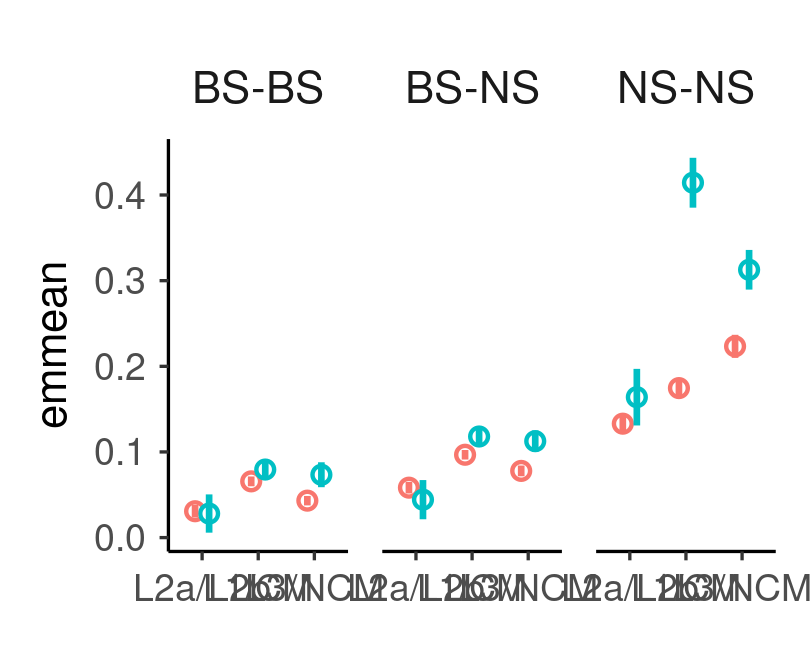

In [17]:
p <- (
    fm_corr
    |> emmeans(~ group*conn_type*area)
    |> confint(level=0.90, type="response")
    |> ggplot(aes(area, emmean, color=group))
    + facet_wrap(~ conn_type)
    + geom_point(position=position_dodge(width=0.5), size=1)
    + geom_linerange(aes(ymin=lower.CL, ymax=upper.CL), position=position_dodge(width=0.5))
    + scale_x_discrete(name=NULL)
    + theme_classic() + my.theme + no.legend
)
p 

### Signal correlation - linear model - pairs

In [20]:
fm_signal_corr <- (
    ucorr
    |> filter(conn_type != "BS-NS")
    |> lm(signal ~ area*conn_type*group, data=_)
)
emmeans(fm_signal_corr, ~ group | area*conn_type) |> contrast("pairwise")

area = L2a/L2b, conn_type = BS-BS:
 contrast  estimate     SE   df t.ratio p.value
 CR - PR  -0.069574 0.0324 8237  -2.148  0.0317

area = L1/CM, conn_type = BS-BS:
 contrast  estimate     SE   df t.ratio p.value
 CR - PR  -0.034944 0.0144 8237  -2.426  0.0153

area = L3/NCM, conn_type = BS-BS:
 contrast  estimate     SE   df t.ratio p.value
 CR - PR   0.000824 0.0214 8237   0.038  0.9693

area = L2a/L2b, conn_type = NS-NS:
 contrast  estimate     SE   df t.ratio p.value
 CR - PR  -0.035891 0.0472 8237  -0.761  0.4466

area = L1/CM, conn_type = NS-NS:
 contrast  estimate     SE   df t.ratio p.value
 CR - PR  -0.139393 0.0425 8237  -3.282  0.0010

area = L3/NCM, conn_type = NS-NS:
 contrast  estimate     SE   df t.ratio p.value
 CR - PR  -0.174621 0.0361 8237  -4.833  <.0001


In [21]:
# compare BS to NS
emmeans(fm_signal_corr, ~ conn_type) |> contrast("pairwise")

NOTE: Results may be misleading due to involvement in interactions



 contrast          estimate    SE   df t.ratio p.value
 (BS-BS) - (NS-NS)    -0.15 0.014 8237 -10.721  <.0001

Results are averaged over the levels of: area, group 

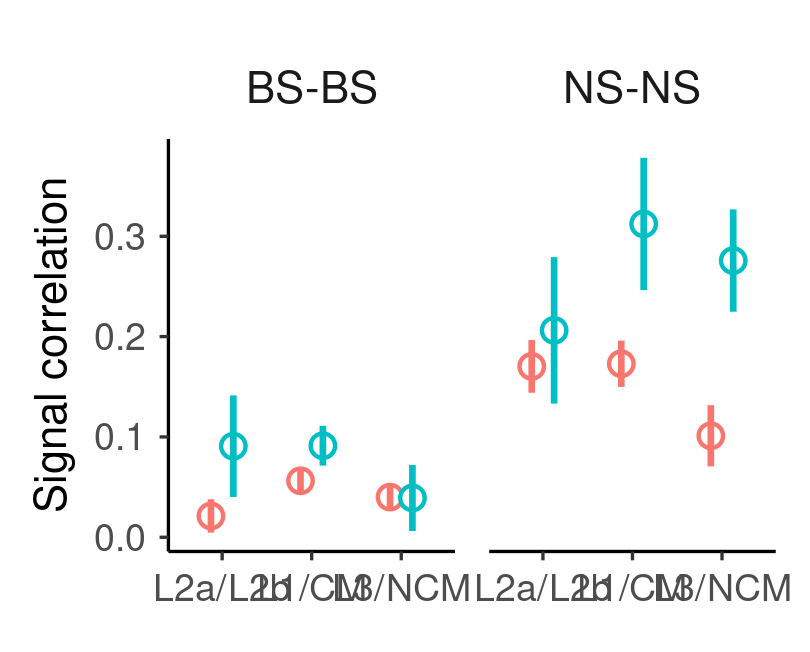

In [22]:
options(repr.plot.width=1.8, repr.plot.height=1.45, repr.plot.res = 450)
p <- (
    fm_signal_corr
    |> emmeans(~ group*conn_type*area)
    |> confint(level=0.90, type="response")
    |> filter(conn_type != "BS-NS")
    |> ggplot(aes(area, emmean, color=group))
    + facet_wrap(~ conn_type)
    + geom_point(position=position_dodge(width=0.5), size=1.5)
    + geom_linerange(aes(ymin=lower.CL, ymax=upper.CL), position=position_dodge(width=0.5))
    + scale_x_discrete(name=NULL)
    + scale_y_continuous("Signal correlation")
    + theme_classic() + my.theme + no.legend
)
p 

In [ ]:
pdf("../figures/signal_correlations.pdf", width=2.4, height=1.75)
print(p)
dev.off()

## Noise vs signal correlations

`geom_smooth()` using formula = 'y ~ x'


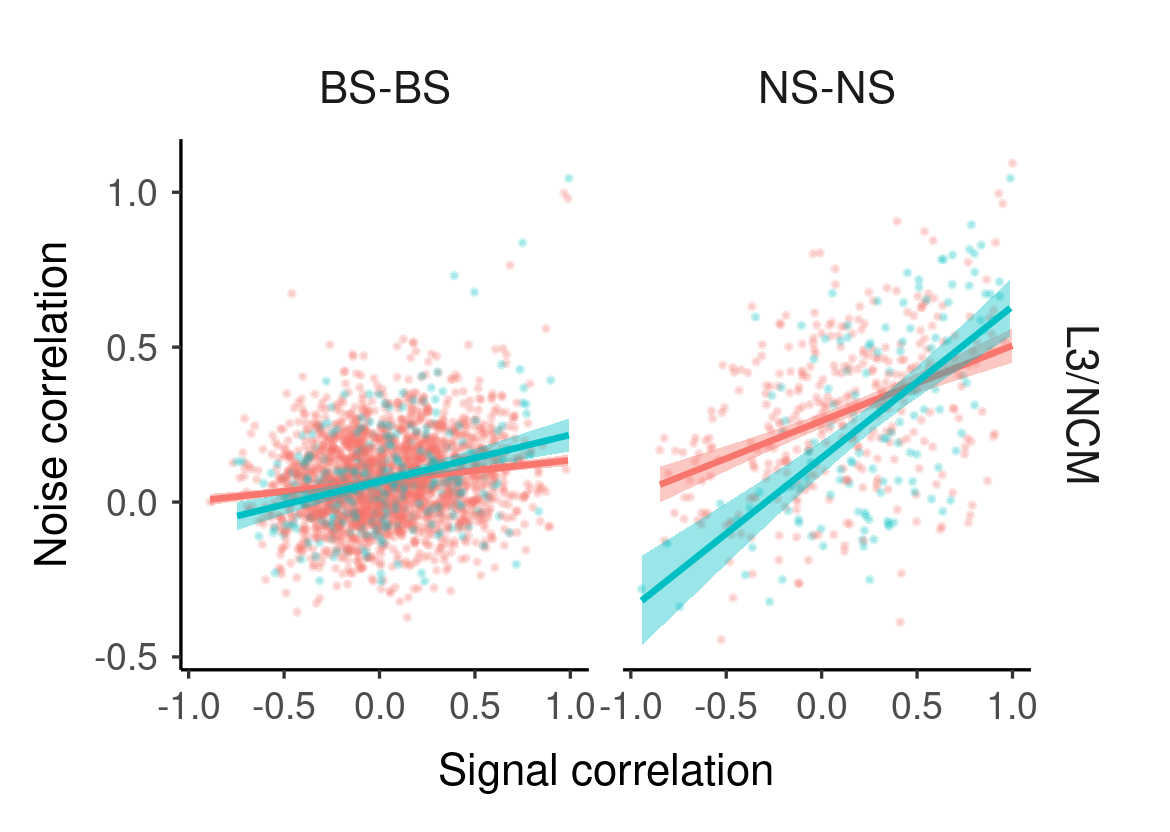

In [25]:
options(repr.plot.width=2.6, repr.plot.height=1.85, repr.plot.res = 450)
p <- (
    ucorr
    |> filter(conn_type != "BS-NS", area=="L3/NCM")
    # |> filter(conn_type != "BS-NS")
    |> ggplot(aes(signal, evoked_noise_c, color=group, fill=group))
    + facet_grid(area ~ conn_type)
    + geom_point(size=0.07, alpha=0.2, shape=21)
    + stat_smooth(method="lm", linewidth=0.5)
    + scale_x_continuous("Signal correlation")
    + scale_y_continuous("Noise correlation")
    + theme_classic() + my.theme + no.legend
)
p

`geom_smooth()` using formula = 'y ~ x'


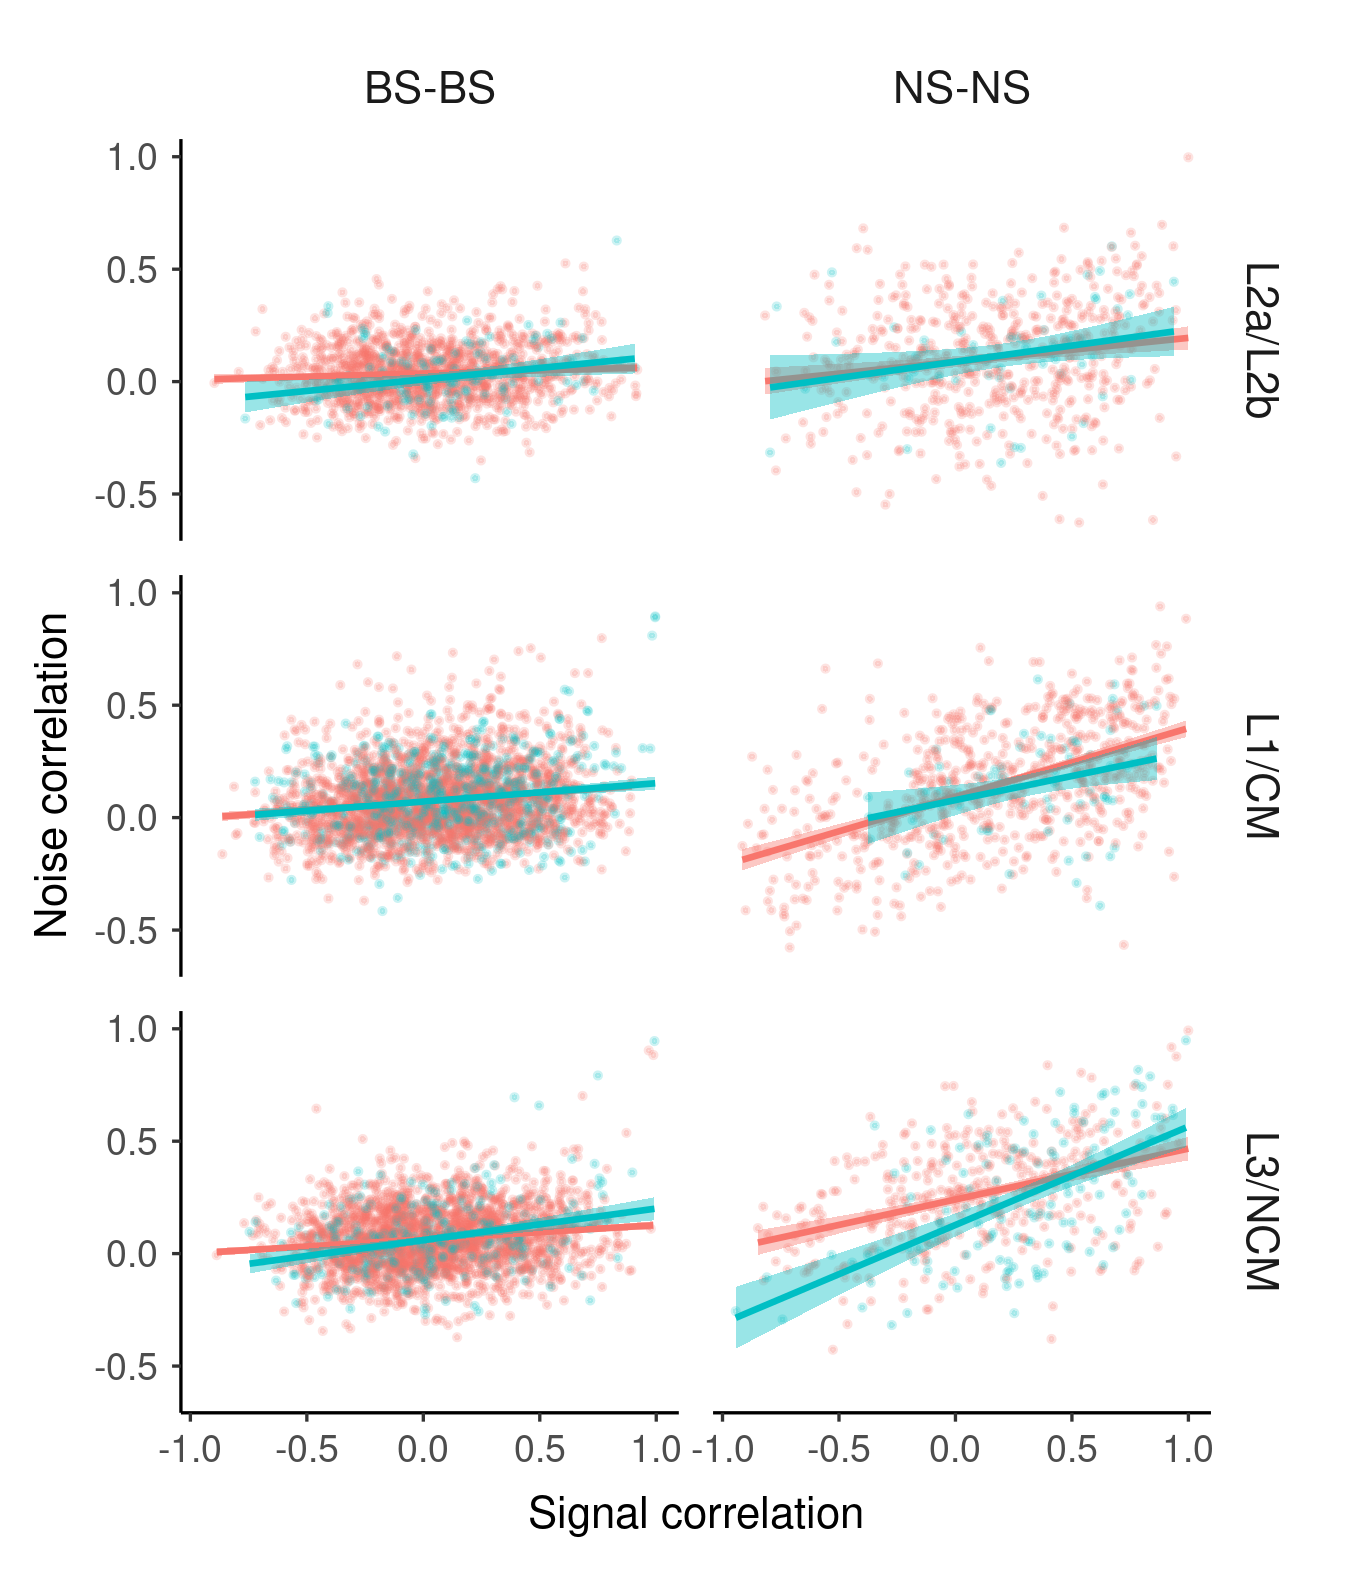

In [26]:
options(repr.plot.width=3.0, repr.plot.height=3.5, repr.plot.res = 450)
p <- (
    ucorr
    |> filter(conn_type != "BS-NS")
    |> ggplot(aes(signal, evoked_noise, color=group, fill=group))
    + facet_grid(area ~ conn_type)
    + geom_point(size=0.1, alpha=0.2, shape=21)
    + stat_smooth(method="lm", linewidth=0.5)
    + scale_x_continuous("Signal correlation")
    + scale_y_continuous("Noise correlation")
    + theme_classic() + my.theme + no.legend
)
p

In [27]:
pdf("../figures/signal_vs_noise_correlations.pdf", width=3.0, height=3.5)
print(p)
dev.off()

`geom_smooth()` using formula = 'y ~ x'


png 
  2

In [28]:
fm_corr_corr <- (
    ucorr
    #|> filter(conn_type != "BS-NS", area=="L3/NCM")
    |> filter(conn_type != "BS-NS")
    |> lm(evoked_noise ~ signal*conn_type*area*group, data=_)
)
em_corr_corr <- emtrends(fm_corr_corr, pairwise ~ group | area*conn_type, var="signal")
summary(em_corr_corr)

,group,area,conn_type,signal.trend,SE,df,lower.CL,upper.CL
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,CR,L2a/L2b,BS-BS,0.02786208,0.01445432,8225,-0.0004720433,0.05619620
2,PR,L2a/L2b,BS-BS,0.10229575,0.04601909,8225,0.0120867156,0.19250478
3,CR,L1/CM,BS-BS,0.07718769,0.01103642,8225,0.0555535232,0.09882185
4,PR,L1/CM,BS-BS,0.08167240,0.01798364,8225,0.0464199338,0.11692487
5,CR,L3/NCM,BS-BS,0.06322615,0.01129141,8225,0.0410921386,0.08536016
6,PR,L3/NCM,BS-BS,0.14049003,0.02835743,8225,0.0849023156,0.19607775
7,CR,L2a/L2b,NS-NS,0.10589851,0.01903967,8225,0.0685759428,0.14322107
8,PR,L2a/L2b,NS-NS,0.14373506,0.05336374,8225,0.0391286623,0.24834147
9,CR,L1/CM,NS-NS,0.30588838,0.01467059,8225,0.2771303076,0.33464644


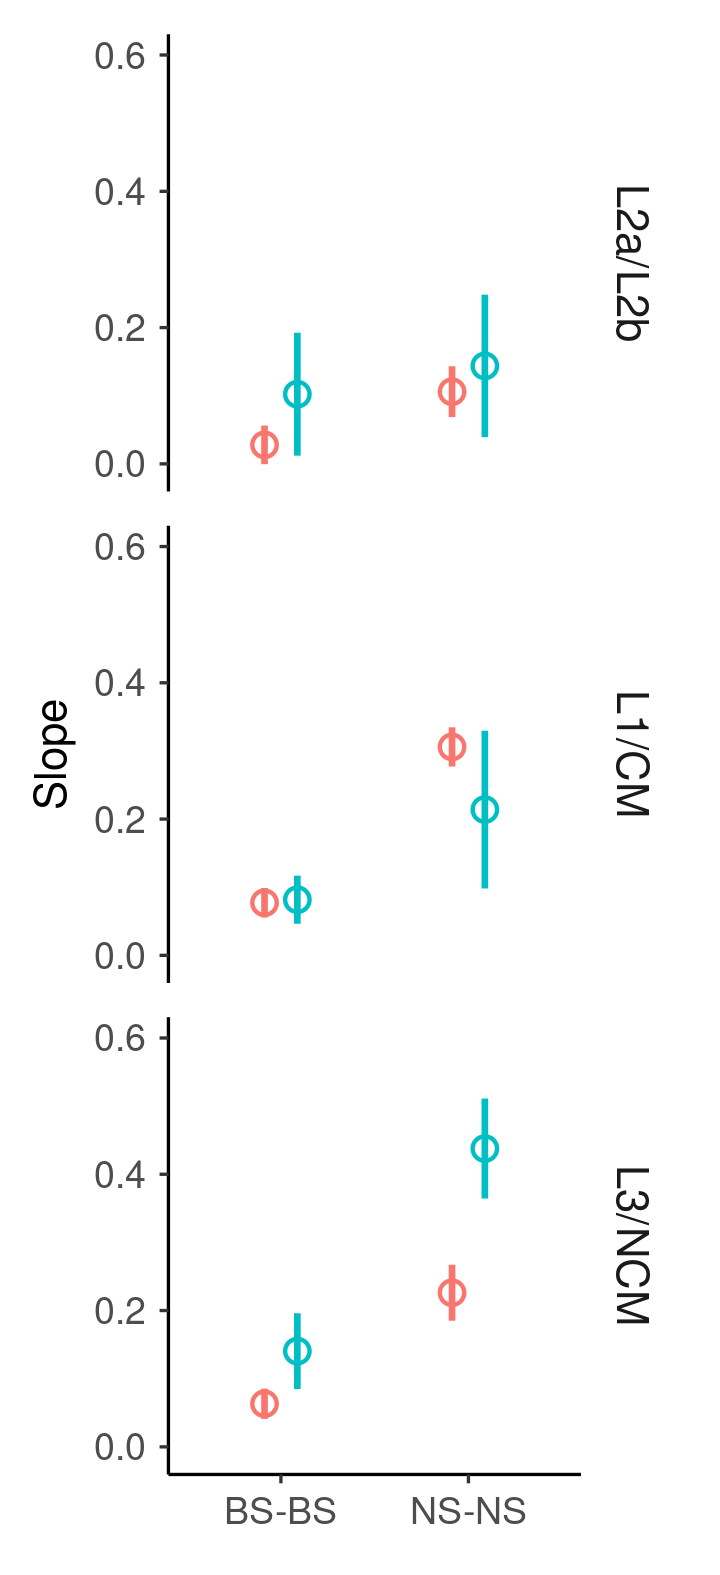

In [29]:
options(repr.plot.width=1.6, repr.plot.height=3.5, repr.plot.res = 450)
p <- (
    summary(em_corr_corr)$emtrends
    |> ggplot(aes(conn_type, signal.trend, color=group))
    + facet_grid(area ~ .)
    + geom_point(position=position_dodge(width=0.35), size=1.5)
    + geom_linerange(aes(ymin=lower.CL, ymax=upper.CL), position=position_dodge(width=0.35))
    + scale_x_discrete(name=NULL)
    + scale_y_continuous("Slope", limits=c(-0.01, 0.6))
    + theme_classic() + my.theme + no.legend
)
p

In [ ]:
pdf("../figures/signal_vs_noise_corr_slope.pdf", width=1.6, height=3.1)
print(p)
dev.off()

NOTE: Results may be misleading due to involvement in interactions



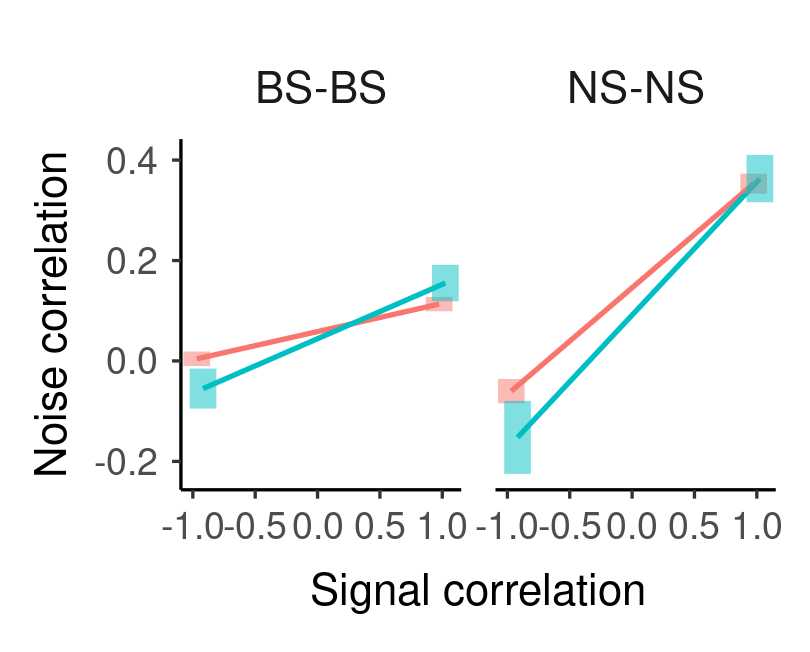

In [30]:
options(repr.plot.width=1.8, repr.plot.height=1.45, repr.plot.res = 450)
(
    emmip(fm_corr_corr, group ~ signal | conn_type, CIs=T, cov.reduce = range)
    + scale_x_continuous("Signal correlation")
    + scale_y_continuous("Noise correlation")
    + theme_classic() + my.theme + no.legend 
)

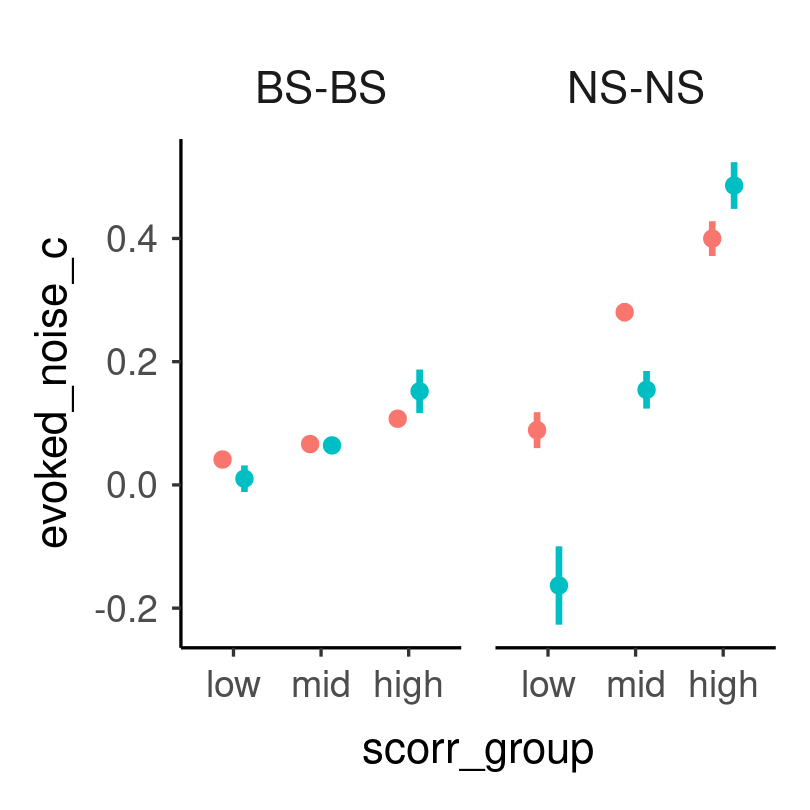

In [31]:
options(repr.plot.width=1.8, repr.plot.height=1.8, repr.plot.res = 450)
(
    ucorr
    |> filter(area=="L3/NCM", conn_type!="BS-NS")
    |> mutate(scorr_group=cut(signal, breaks=c(-1, -0.4, 0.4, 1), labels=c("low", "mid", "high")))
    |> ggplot(aes(scorr_group, evoked_noise_c, color=group))
    + facet_grid(~ conn_type)
    + stat_summary(fun.data="mean_se", fatten=0.1, position=position_dodge(width=0.5))
    + theme_classic() + my.theme + no.legend
)